# PYSPARKによる銀行の顧客の予測

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

https://www.kaggle.com/janiobachmann/bank-marketing-dataset

### PS　いまいち認識があいまいな概念の整理  
https://techblog.recruitjobs.net/development/basic_data_types_of_spark  
RDDとデータフレームの違い？  


RDDは並列処理可能なデータ形式。  
並列処理の時に、これを使うと、理解します。  
操作とか、はいったん理解しています。  
map reduceのメソッドはよく使います。  

データフレームは、型などの情報を与えるやつ。  
いわゆる構造化  
より最適化された計算を実現します。  
データフレームも同じくmap reduceなどで、並行処理できるみたい

https://yubessy.hatenablog.com/entry/2016/12/11/095915  
RDD  
✅ データ処理が型安全である  
✅ ユーザ定義の型を扱うことができる  
❌ パフォーマンスが低い  
❌ アドホックなクエリ処理が書きにくい  
DataFrame  
✅ パフォーマンスが高い  
✅ SQLを用いてアドホックな処理が書ける  
❌ データ処理が型安全でない  
❌ 一部の基本的な型の値しか扱うことができない  

### そのため！  
オフィシャルドキュメントも、RDDベースとDFベースのAPIがあり売ます。  
でも、でもでも、  
### 発表: データフレームに基づいたAPIは主要なAPIです
と書いてあるので、  
基本的にDFベースの捜査ができればオッケーだと思います。  

http://mogile.web.fc2.com/spark/spark200/ml-guide.html

http://mogile.web.fc2.com/spark/spark200/mllib-guide.html

### データに対する解釈なし

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

In [3]:
df = spark.read.csv('./data_bank/bank.csv',header=True,inferSchema=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



以上のようなデータはとにかくあります。  

行列を反転して見やすい

In [4]:
pd.DataFrame(df.take(5),columns=df.columns).T

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [5]:
df.groupBy('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



直感的に言うと、半分半分

In [6]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

数値的なデータを抽出、  


### 欠損値と異常値を見てみる

In [7]:
from pyspark.sql.functions import col
cols = df.columns
for c in cols:
    count = df.filter(col(c).isNull()).count()
    print (c , count)

age 0
job 0
marital 0
education 0
default 0
balance 0
housing 0
loan 0
contact 0
day 0
month 0
duration 0
campaign 0
pdays 0
previous 0
poutcome 0
deposit 0


欠損値はとにかくないということがわかりました

続いて異常値を見てみます。  
とりあえず、数値のデータを抽出して異常値を観察します。

In [8]:
numeric_features = [dtypes[0] for dtypes in df.dtypes if dtypes[1]=='int']
numeric_data = df[numeric_features]
print(numeric_features)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


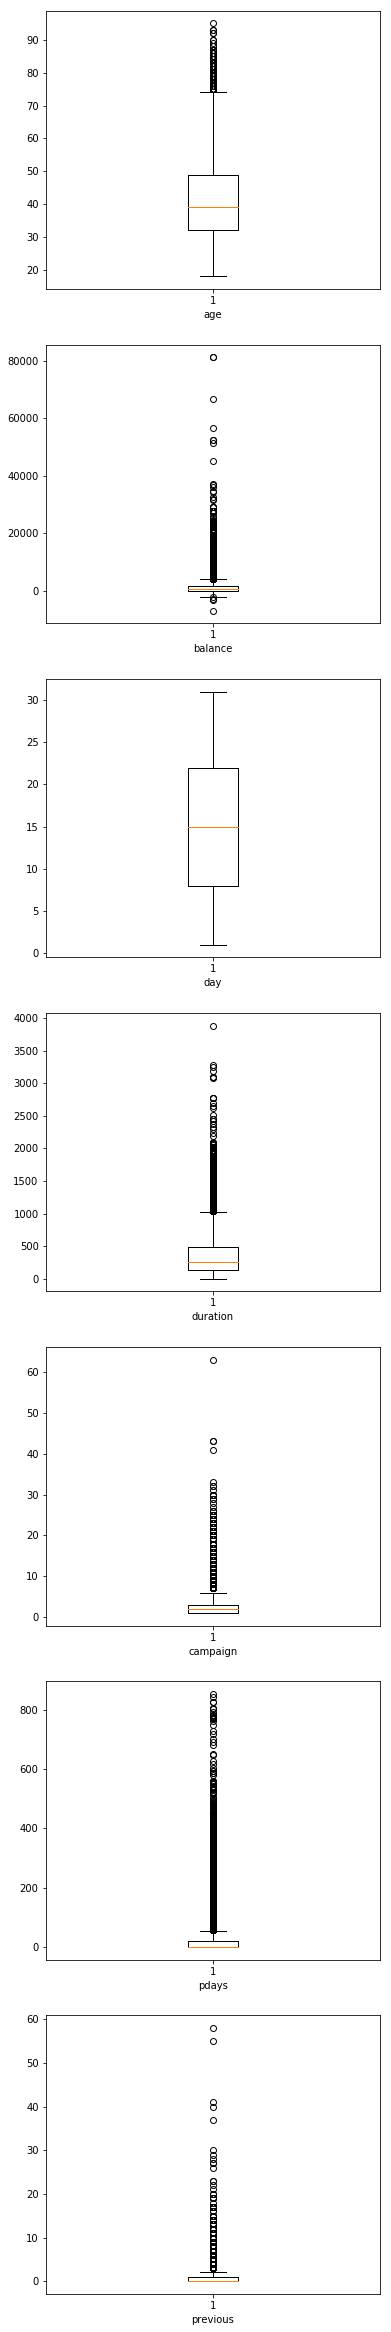

In [9]:
fig = plt.figure(figsize=(6,42))

for i,co in enumerate(numeric_features):
    ax = plt.subplot(7,1,i+1)
    ax.boxplot(df.toPandas()[co])
    ax.set_xlabel(co)

特に非常に外れている値や、マイナスなどはないみたいです。  

### 基礎集計

分布を見る

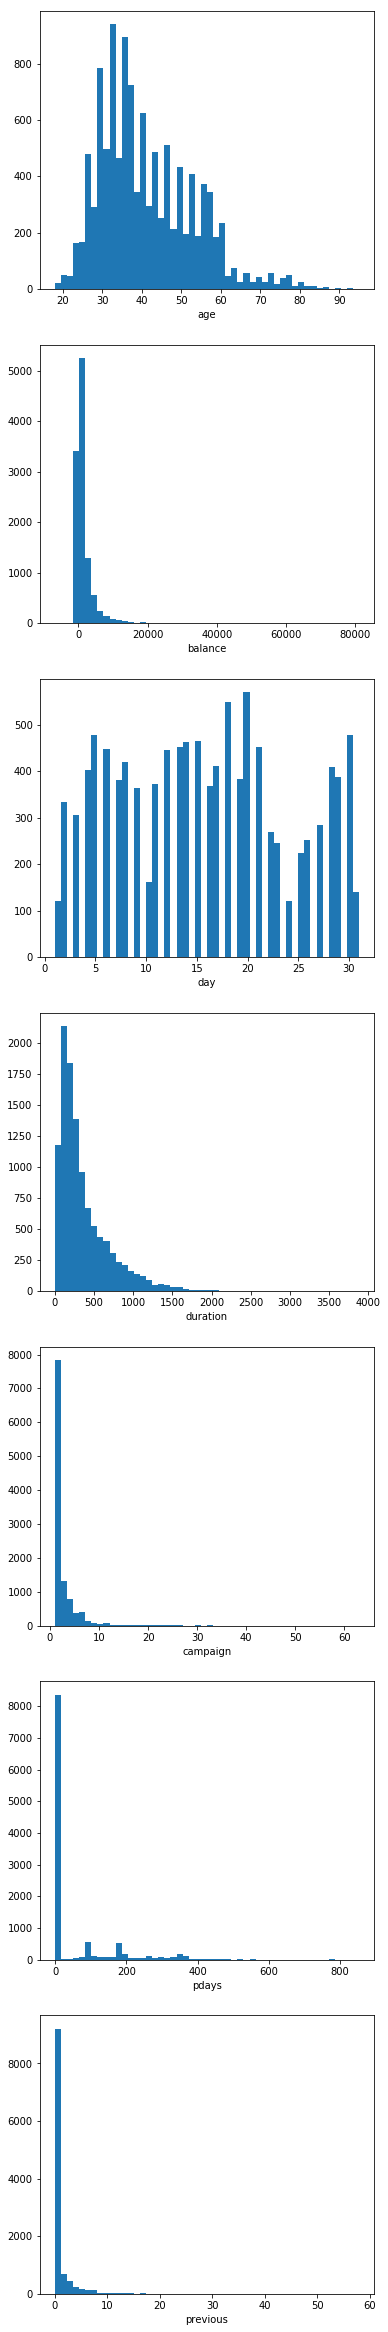

In [10]:
fig = plt.figure(figsize=(6,42))

for i,co in enumerate(numeric_features):
    ax = plt.subplot(7,1,i+1)
    ax.hist(df.toPandas()[co],bins=50)
    ax.set_xlabel(co)

特徴量作成・特徴量準備

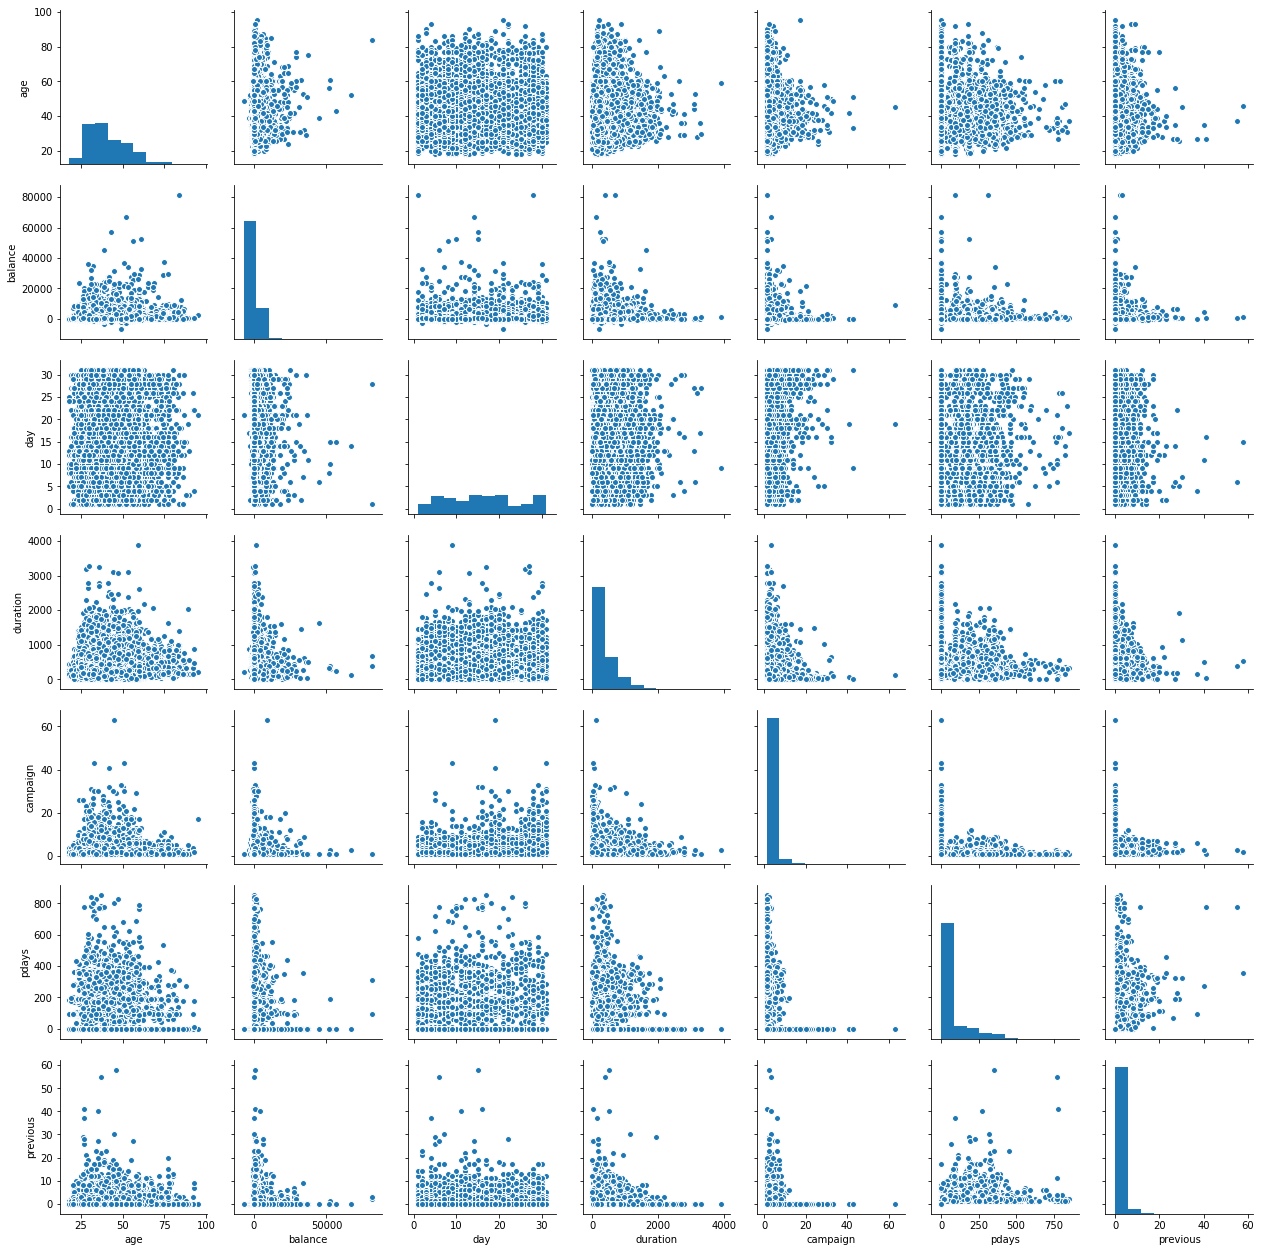

In [11]:
sns.pairplot(numeric_data.toPandas());

非常に相関しそうな特徴量はないみたいです。  
削除すべきものもなさそうです。  

カテゴリー変数をdummyにします

### Pipeline データの処理

pipelineの概念もいまいちあいまい！  
  
データフレーム: このML APIはMLデータセットとしてSpark SQLからデータフレームを使用します。これは様々なデータタイプを保持します。例えば、データフレーム はテキスト、特徴ベクトル、trueのラベル、および予想を格納する異なるカラムを持つことができます。  

変換器: Transformer は一つの データフレーム を他の データフレームに変換することができるアルゴリズムです。例えば、MLモデルは 特徴量を持つデータフレームを予想を持つデータフレーム に変換する変換器です。  

予測器: 予測器 は変換器を生成するために データフレームにうまく当てはめることができるアルゴリズムです。例えば、学習アルゴリズムはデータフレームを教育しモデルを生成する予測器 です。  

パイプライン: パイプライン はMLワークフローを指定するために複数の変換器と予測器を一緒につなげます。  

パラメータ: 全ての 変換器 と予測器はパラメータを指定するための共通のAPIを今では共有します。  

私の理解：  
パイプラインは、複数の機械が入っているコンテナ見たいです。  
データをコンテナの左側に入れて、様々な機械で様々な加工をして、右側に出力。  
機械が加工する過程はワークフローといいましょう  

機械は、先ほどの変換器で加工するだけではなくて、予測器も入っている可能性があります。  
とにかくこれは一連の処理が格納されているコンテナです。  

書き方  
A処理を定義  
>val tokenizer = new Tokenizer()  
  .setInputCol("text")  
  .setOutputCol("words")  

B処理を定義  
>  val hashingTF = new HashingTF()  
  .setNumFeatures(1000)  
  .setInputCol(tokenizer.getOutputCol)  
  .setOutputCol("features")  

C処理を定義  
>   val lr = new LogisticRegression()  
  .setMaxIter(10)  
  .setRegParam(0.01)  

pipelineを定義(ABC処理をパイプラインに格納)  
>　val pipeline = new Pipeline()  
  .setStages(Array(tokenizer, hashingTF, lr))  

最後パイプラインで、データを処理  
>val model = pipeline.fit(training)

In [12]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [13]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [14]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()


,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [15]:
train,test = df.randomSplit([0.7,0.3],seed = 0)
print('train:',train.count())

train: 7876


In [16]:
from pyspark.ml.classification import LogisticRegression  
lr = LogisticRegression(featuresCol='features',labelCol='label',maxIter=10)
lrModel = lr.fit(train)

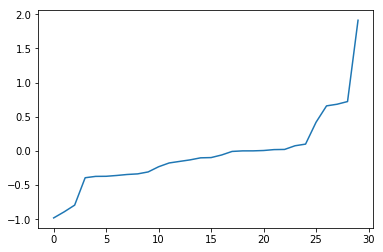

In [18]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)

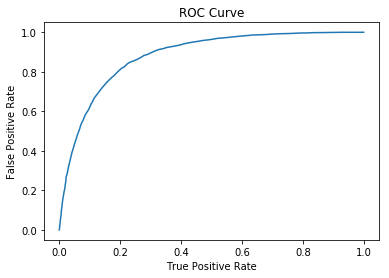

Training set areaUnderROC: 0.8808626717826935


In [19]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))